In [1]:
import numpy as np
import pandas as pd
import pandas_datareader.data as pdr
import matplotlib.pyplot as plt

import datetime

import torch
import torch.nn as nn
from torch.autograd import Variable

import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

!pip install yfinance # yfinance 모듈 설치
import yfinance as yf  # yfinance 모듈 임포트

[*********************100%***********************]  1 of 1 completed

              Open    High     Low   Close    Adj Close    Volume
Date                                                             
2000-01-04  6000.0  6110.0  5660.0  6110.0  4429.952148  74195000
2000-01-05  5800.0  6060.0  5520.0  5580.0  4045.681396  74680000
2000-01-06  5750.0  5780.0  5580.0  5620.0  4074.686279  54390000
2000-01-07  5560.0  5670.0  5360.0  5540.0  4016.682861  40305000
2000-01-10  5600.0  5770.0  5580.0  5770.0  4183.439941  46880000
               Open     High      Low    Close  Adj Close    Volume
Date                                                               
2024-09-11  65100.0  65500.0  64200.0  64900.0    64900.0  35809707
2024-09-12  66000.0  66600.0  65200.0  66300.0    66300.0  35884106
2024-09-13  65000.0  65500.0  64300.0  64400.0    64400.0  25045135
2024-09-19  64000.0  64400.0  62200.0  63100.0    63100.0  49402713
2024-09-20  63800.0  64700.0  63000.0  63000.0    63000.0  32746056


<Axes: xlabel='Date'>

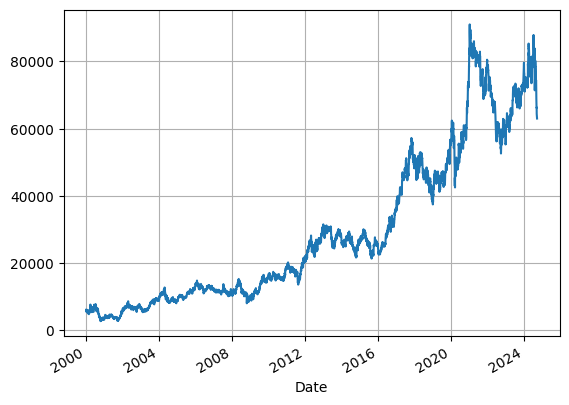

In [3]:
start = (2000, 1, 1)  # 2000년 01년 01월
start = datetime.datetime(*start)
end = datetime.date.today()  # 현재

# pandas_datareader가 작동하지 않으므로 yfinance를 사용하여 데이터 가져오기
df = yf.download('005930.KS', start=start, end=end)


print(df.head(5))
print(df.tail(5))
df.Close.plot(grid=True)

In [4]:
#open 시가/high 고가/low 저가/close 종가/ volume 거래량

X = df.drop(columns='Volume')#거래량은 데이터에서 제외
y = df.iloc[:, 5:6]

print(X)
print(y)

               Open     High      Low    Close     Adj Close
Date                                                        
2000-01-04   6000.0   6110.0   5660.0   6110.0   4429.952148
2000-01-05   5800.0   6060.0   5520.0   5580.0   4045.681396
2000-01-06   5750.0   5780.0   5580.0   5620.0   4074.686279
2000-01-07   5560.0   5670.0   5360.0   5540.0   4016.682861
2000-01-10   5600.0   5770.0   5580.0   5770.0   4183.439941
...             ...      ...      ...      ...           ...
2024-09-11  65100.0  65500.0  64200.0  64900.0  64900.000000
2024-09-12  66000.0  66600.0  65200.0  66300.0  66300.000000
2024-09-13  65000.0  65500.0  64300.0  64400.0  64400.000000
2024-09-19  64000.0  64400.0  62200.0  63100.0  63100.000000
2024-09-20  63800.0  64700.0  63000.0  63000.0  63000.000000

[6194 rows x 5 columns]
              Volume
Date                
2000-01-04  74195000
2000-01-05  74680000
2000-01-06  54390000
2000-01-07  40305000
2000-01-10  46880000
...              ...
2024-09-11  35

In [5]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
mm = MinMaxScaler()
ss = StandardScaler()

X_ss = ss.fit_transform(X)
y_mm = mm.fit_transform(y)

# Train Data
X_train = X_ss[:4500, :]
X_test = X_ss[4500:, :]

#Test Data
y_train = y_mm[:4500, :]
y_test = y_mm[4500:, :]

print("Training Shape", X_train.shape, y_train.shape)
print("Testing Shape", X_test.shape, y_test.shape)

Training Shape (4500, 5) (4500, 1)
Testing Shape (1694, 5) (1694, 1)


In [6]:
X_train_tensors = torch.Tensor(X_train)
X_test_tensors = torch.Tensor(X_test)

y_train_tensors = torch.Tensor(y_train)
y_test_tensors = torch.Tensor(y_test)

X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
X_test_tensors_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1]))

print("Training Shape", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_final.shape, y_test_tensors.shape)


Training Shape torch.Size([4500, 1, 5]) torch.Size([4500, 1])
Testing Shape torch.Size([1694, 1, 5]) torch.Size([1694, 1])


In [7]:
device= torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [8]:
class LSTM1(nn.Module):
  def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
    super(LSTM1, self).__init__()
    self.num_classes = num_classes #number of classes
    self.num_layers = num_layers #number of layers
    self.input_size = input_size #input size
    self.hidden_size = hidden_size #hidden state
    self.seq_length = seq_length #sequence length

    self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                      num_layers=num_layers, batch_first=True) #lstm
    self.fc_1 =  nn.Linear(hidden_size, 128) #fully connected 1
    self.fc = nn.Linear(128, num_classes) #fully connected last layer

    self.relu = nn.ReLU()

  def forward(self,x):
    h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) #hidden state
    c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) #internal state
    # Propagate input through LSTM

    output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state

    hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
    out = self.relu(hn)
    out = self.fc_1(out) #first Dense
    out = self.relu(out) #relu
    out = self.fc(out) #Final Output

    return out


In [9]:
#네트워크 파라미터 구성하기
num_epochs = 30000 #1000 epochs
learning_rate = 0.00001 #0.001 lr

input_size = 5 #number of features
hidden_size = 2 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes

In [10]:
lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, X_train_tensors_final.shape[1]).to(device)

loss_function = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate)  # adam optimizer

In [11]:
#학습하기
for epoch in range(num_epochs):
  outputs = lstm1.forward(X_train_tensors_final.to(device)) #forward pass
  optimizer.zero_grad() #caluclate the gradient, manually setting to 0

  # obtain the loss function
  loss = loss_function(outputs, y_train_tensors.to(device))

  loss.backward() #calculates the loss of the loss function

  optimizer.step() #improve from loss, i.e backprop
  if epoch % 100 == 0:
    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.02919
Epoch: 100, loss: 0.02160
Epoch: 200, loss: 0.01654
Epoch: 300, loss: 0.01339
Epoch: 400, loss: 0.01159
Epoch: 500, loss: 0.01065
Epoch: 600, loss: 0.01020
Epoch: 700, loss: 0.01001
Epoch: 800, loss: 0.00994
Epoch: 900, loss: 0.00992
Epoch: 1000, loss: 0.00991
Epoch: 1100, loss: 0.00991
Epoch: 1200, loss: 0.00991
Epoch: 1300, loss: 0.00991
Epoch: 1400, loss: 0.00991
Epoch: 1500, loss: 0.00991
Epoch: 1600, loss: 0.00991
Epoch: 1700, loss: 0.00990
Epoch: 1800, loss: 0.00990
Epoch: 1900, loss: 0.00990
Epoch: 2000, loss: 0.00990
Epoch: 2100, loss: 0.00990
Epoch: 2200, loss: 0.00990
Epoch: 2300, loss: 0.00990
Epoch: 2400, loss: 0.00990
Epoch: 2500, loss: 0.00990
Epoch: 2600, loss: 0.00990
Epoch: 2700, loss: 0.00989
Epoch: 2800, loss: 0.00989
Epoch: 2900, loss: 0.00989
Epoch: 3000, loss: 0.00989
Epoch: 3100, loss: 0.00989
Epoch: 3200, loss: 0.00989
Epoch: 3300, loss: 0.00988
Epoch: 3400, loss: 0.00988
Epoch: 3500, loss: 0.00988
Epoch: 3600, loss: 0.00988
Epoch: 3700, 

In [12]:
#예측하기
df_X_ss = ss.transform(df.drop(columns='Volume'))
df_y_mm = mm.transform(df.iloc[:, 5:6])

df_X_ss = Variable(torch.Tensor(df_X_ss)) #converting to Tensors
df_y_mm = Variable(torch.Tensor(df_y_mm))
#reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 1, df_X_ss.shape[1]))

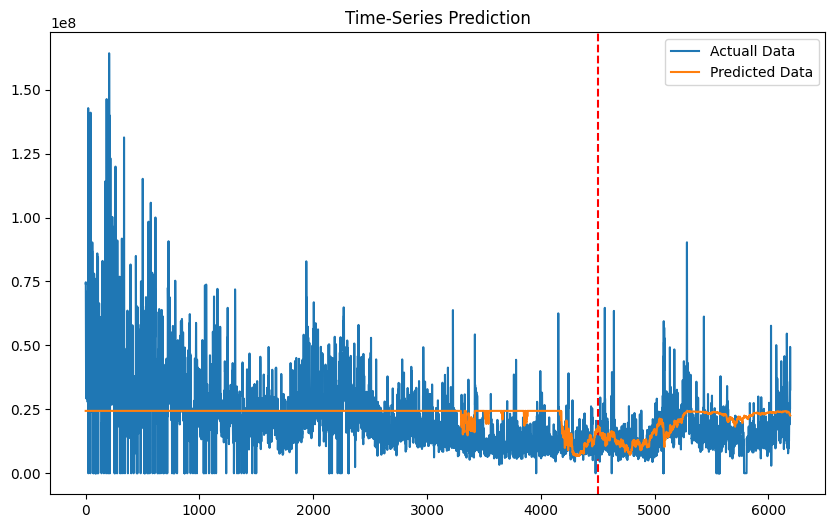

In [15]:
train_predict = lstm1(df_X_ss.to(device))#forward pass
data_predict = train_predict.data.detach().cpu().numpy() #numpy conversion
dataY_plot = df_y_mm.data.numpy()

data_predict = mm.inverse_transform(data_predict) #reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot)
plt.figure(figsize=(10,6)) #plotting
plt.axvline(x=4500, c='r', linestyle='--') #size of the training set

plt.plot(dataY_plot, label='Actuall Data') #actual plot
plt.plot(data_predict, label='Predicted Data') #predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.show()
